<a href="https://colab.research.google.com/github/sparsh-ai/reco-book/blob/stage/nbs/T632722_PyTorch_Fundamentals_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Fundamentals Part 1

## The Hot Problem

<img src='https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781617295263/files/OEBPS/Images/CH05_F02_Stevens2_GS.png'>

In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt

%matplotlib inline

torch.set_printoptions(edgeitems=2, linewidth=75)

We just got back from a trip to some obscure location, and we brought back a fancy, wall-mounted analog thermometer. It looks great, and it’s a perfect fit for our living room. Its only flaw is that it doesn’t show units. Not to worry, we’ve got a plan: we’ll build a dataset of readings and corresponding temperature values in our favorite units, choose a model, adjust its weights iteratively until a measure of the error is low enough, and finally be able to interpret the new readings in units we understand.

We’ll start by making a note of temperature data in good old Celsius and measurements from our new thermometer, and figure things out. After a couple of weeks, here’s the data:

In [ ]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Here, the t_c values are temperatures in Celsius, and the t_u values are our unknown units. We can expect noise in both measurements, coming from the devices themselves and from our approximate readings. For convenience, we’ve already put the data into tensors; we’ll use it in a minute.

A quick plot of our data tells us that it’s noisy, but we think there’s a pattern here.

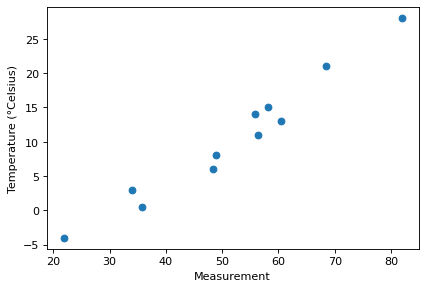

In [ ]:
fig = plt.figure(dpi=80)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.show()

In the absence of further knowledge, we assume the simplest possible model for converting between the two sets of measurements, just like Kepler might have done. The two may be linearly related--that is, multiplying t_u by a factor and adding a constant, we may get the temperature in Celsius (up to an error that we omit):

Is this a reasonable assumption? Probably; we’ll see how well the final model performs. We chose to name w and b after weight and bias, two very common terms for linear scaling and the additive constant--we’ll bump into those all the time.

OK, now we need to estimate w and b, the parameters in our model, based on the data we have. We must do it so that temperatures we obtain from running the unknown temperatures t_u through the model are close to temperatures we actually measured in Celsius. If that sounds like fitting a line through a set of measurements, well, yes, because that’s exactly what we’re doing. We’ll go through this simple example using PyTorch and realize that training a neural network will essentially involve changing the model for a slightly more elaborate one, with a few (or a metric ton) more parameters.

Let’s flesh it out again: we have a model with some unknown parameters, and we need to estimate those parameters so that the error between predicted outputs and measured values is as low as possible. We notice that we still need to exactly define a measure of the error. Such a measure, which we refer to as the loss function, should be high if the error is high and should ideally be as low as possible for a perfect match. Our optimization process should therefore aim at finding w and b so that the loss function is at a minimum.

In [ ]:
def model(t_u, w, b):
    return w * t_u + b

A loss function (or cost function) is a function that computes a single numerical value that the learning process will attempt to minimize. The calculation of loss typically involves taking the difference between the desired outputs for some training samples and the outputs actually produced by the model when fed those samples. In our case, that would be the difference between the predicted temperatures t_p output by our model and the actual measurements: t_p - t_c.

We need to make sure the loss function makes the loss positive both when t_p is greater than and when it is less than the true t_c, since the goal is for t_p to match t_c. We have a few choices, the most straightforward being |t_p - t_c| and (t_p - t_c)^2. Based on the mathematical expression we choose, we can emphasize or discount certain errors. Conceptually, a loss function is a way of prioritizing which errors to fix from our training samples, so that our parameter updates result in adjustments to the outputs for the highly weighted samples instead of changes to some other samples’ output that had a smaller loss.

Both of the example loss functions have a clear minimum at zero and grow monotonically as the predicted value moves further from the true value in either direction. Because the steepness of the growth also monotonically increases away from the minimum, both of them are said to be convex. Since our model is linear, the loss as a function of w and b is also convex. Cases where the loss is a convex function of the model parameters are usually great to deal with because we can find a minimum very efficiently through specialized algorithms. However, we will instead use less powerful but more generally applicable methods in this chapter. We do so because for the deep neural networks we are ultimately interested in, the loss is not a convex function of the inputs.

For our two loss functions |t_p - t_c| and (t_p - t_c)^2, we notice that the square of the differences behaves more nicely around the minimum: the derivative of the error-squared loss with respect to t_p is zero when t_p equals t_c. The absolute value, on the other hand, has an undefined derivative right where we’d like to converge. This is less of an issue in practice than it looks like, but we’ll stick to the square of differences for the time being.

<img src='https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781617295263/files/OEBPS/Images/CH05_F04_Stevens2_GS.png'>

We’re expecting t_u, w, and b to be the input tensor, weight parameter, and bias parameter, respectively. In our model, the parameters will be PyTorch scalars (aka zero-dimensional tensors), and the product operation will use broadcasting to yield the returned tensors. Anyway, time to define our loss:

In [ ]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

Note that we are building a tensor of differences, taking their square element-wise, and finally producing a scalar loss function by averaging all of the elements in the resulting tensor. It is a mean square loss.

We can now initialize the parameters, invoke the model:

In [ ]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

and check the value of the loss:

In [ ]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

We implemented the model and the loss in this section. We’ve finally reached the meat of the example: how do we estimate w and b such that the loss reaches a minimum? We’ll first work things out by hand and then learn how to use PyTorch’s superpowers to solve the same problem in a more general, off-the-shelf way.

We’ll optimize the loss function with respect to the parameters using the gradient descent algorithm. Gradient descent is actually a very simple idea, and it scales up surprisingly well to large neural network models with millions of parameters. Let’s start with a mental image. Suppose we are in front of a machine sporting two knobs, labeled w and b. We are allowed to see the value of the loss on a screen, and we are told to minimize that value. Not knowing the effect of the knobs on the loss, we start fiddling with them and decide for each knob which direction makes the loss decrease. We decide to rotate both knobs in their direction of decreasing loss. Suppose we’re far from the optimal value: we’d likely see the loss decrease quickly and then slow down as it gets closer to the minimum. We notice that at some point, the loss climbs back up again, so we invert the direction of rotation for one or both knobs. We also learn that when the loss changes slowly, it’s a good idea to adjust the knobs more finely, to avoid reaching the point where the loss goes back up. After a while, eventually, we converge to a minimum.

<img src='https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781617295263/files/OEBPS/Images/CH05_F06_Stevens2_GS.png'>

Gradient descent is not that different from the scenario we just described. The idea is to compute the rate of change of the loss with respect to each parameter, and modify each parameter in the direction of decreasing loss. Just like when we were fiddling with the knobs, we can estimate the rate of change by adding a small number to w and b and seeing how much the loss changes in that neighborhood:

In [ ]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

This is saying that in the neighborhood of the current values of w and b, a unit increase in w leads to some change in the loss. If the change is negative, then we need to increase w to minimize the loss, whereas if the change is positive, we need to decrease w. By how much? Applying a change to w that is proportional to the rate of change of the loss is a good idea, especially when the loss has several parameters: we apply a change to those that exert a significant change on the loss. It is also wise to change the parameters slowly in general, because the rate of change could be dramatically different at a distance from the neighborhood of the current w value. Therefore, we typically should scale the rate of change by a small factor. This scaling factor has many names; the one we use in machine learning is learning_rate:

In [ ]:
learning_rate = 1e-2
 
w = w - learning_rate * loss_rate_of_change_w

We can do the same with b:

In [ ]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) -
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
 
b = b - learning_rate * loss_rate_of_change_b

This represents the basic parameter-update step for gradient descent. By reiterating these evaluations (and provided we choose a small enough learning rate), we will converge to an optimal value of the parameters for which the loss computed on the given data is minimal. We’ll show the complete iterative process soon, but the way we just computed our rates of change is rather crude and needs an upgrade before we move on. Let’s see why and how.

Computing the rate of change by using repeated evaluations of the model and loss in order to probe the behavior of the loss function in the neighborhood of w and b doesn’t scale well to models with many parameters. Also, it is not always clear how large the neighborhood should be. We chose delta equal to 0.1 in the previous section, but it all depends on the shape of the loss as a function of w and b. If the loss changes too quickly compared to delta, we won’t have a very good idea of in which direction the loss is decreasing the most.

What if we could make the neighborhood infinitesimally small? That’s exactly what happens when we analytically take the derivative of the loss with respect to a parameter. In a model with two or more parameters like the one we’re dealing with, we compute the individual derivatives of the loss with respect to each parameter and put them in a vector of derivatives: the gradient.

In order to compute the derivative of the loss with respect to a parameter, we can apply the chain rule and compute the derivative of the loss with respect to its input (which is the output of the model), times the derivative of the model with respect to the parameter:

In [ ]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

def dmodel_dw(t_u, w, b):
    return t_u
 
def dmodel_db(t_u, w, b):
    return 1.0

<img src='https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781617295263/files/OEBPS/Images/CH05_F07_Stevens2_GSII.png'>

Putting all of this together, the function returning the gradient of the loss with respect to w and b is:

In [ ]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

We now have everything in place to optimize our parameters. Starting from a tentative value for a parameter, we can iteratively apply updates to it for a fixed number of iterations, or until w and b stop changing. There are several stopping criteria; for now, we’ll stick to a fixed number of iterations.

In [ ]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break
            
    return params

In [ ]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
    Params: tensor([2568.4011,   45.1637])
    Grad:   tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
    Params: tensor([-148527.7344,   -2616.3931])
    Grad:   tensor([15109614.0000,   266155.6875])
...
Epoch 10, Loss 90901105189019073810297959556841472.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

Wait, what happened? Our training process literally blew up, leading to losses becoming inf. This is a clear sign that params is receiving updates that are too large, and their values start oscillating back and forth as each update overshoots and the next overcorrects even more. The optimization process is unstable: it diverges instead of converging to a minimum. We want to see smaller and smaller updates to params, not larger.

How can we limit the magnitude of learning_rate * grad? Well, that looks easy. We could simply choose a smaller learning_rate, and indeed, the learning rate is one of the things we typically change when training does not go as well as we would like. We usually change learning rates by orders of magnitude, so we might try with 1e-3 or 1e-4, which would decrease the magnitude of the updates by orders of magnitude. Let’s go with 1e-4 and see how it works out:

In [ ]:
training_loop(
    n_epochs = 100,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

Nice--the behavior is now stable. But there’s another problem: the updates to parameters are very small, so the loss decreases very slowly and eventually stalls. We could obviate this issue by making learning_rate adaptive: that is, change according to the magnitude of updates.

However, there’s another potential troublemaker in the update term: the gradient itself. Let’s go back and look at grad at epoch 1 during optimization.

We can see that the first-epoch gradient for the weight is about 50 times larger than the gradient for the bias. This means the weight and bias live in differently scaled spaces. If this is the case, a learning rate that’s large enough to meaningfully update one will be so large as to be unstable for the other; and a rate that’s appropriate for the other won’t be large enough to meaningfully change the first. That means we’re not going to be able to update our parameters unless we change something about our formulation of the problem. We could have individual learning rates for each parameter, but for models with many parameters, this would be too much to bother with; it’s babysitting of the kind we don’t like.

There’s a simpler way to keep things in check: changing the inputs so that the gradients aren’t quite so different. We can make sure the range of the input doesn’t get too far from the range of -1.0 to 1.0, roughly speaking. In our case, we can achieve something close enough to that by simply multiplying t_u by 0.1:

In [ ]:
t_un = 0.1 * t_u

Here, we denote the normalized version of t_u by appending an n to the variable name. At this point, we can run the training loop on our normalized input:

In [ ]:
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

Let’s run the loop for enough iterations to see the changes in params get small. We’ll change n_epochs to 5,000:

In [ ]:
params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c,
    print_params = False)

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


In [ ]:
print('W={} and b={}'.format(params[0].item(), params[1].item()))

W=5.367083549499512 and b=-17.301189422607422


Good: our loss decreases while we change parameters along the direction of gradient descent. It doesn’t go exactly to zero; this could mean there aren’t enough iterations to converge to zero, or that the data points don’t sit exactly on a line. As we anticipated, our measurements were not perfectly accurate, or there was noise involved in the reading.

But look: the values for w and b look an awful lot like the numbers we need to use to convert Celsius to Fahrenheit (after accounting for our earlier normalization when we multiplied our inputs by 0.1). The exact values would be w=5.5556 and b=-17.7778. Our fancy thermometer was showing temperatures in Fahrenheit the whole time. No big discovery, except that our gradient descent optimization process works!

Let’s revisit something we did right at the start: plotting our data. Seriously, this is the first thing anyone doing data science should do. Always plot the heck out of the data:

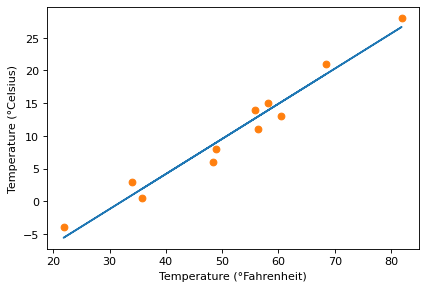

In [ ]:
t_p = model(t_un, *params)

fig = plt.figure(dpi=80)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.show()

In our little adventure, we just saw a simple example of backpropagation: we computed the gradient of a composition of functions--the model and the loss--with respect to their innermost parameters (w and b) by propagating derivatives backward using the chain rule. The basic requirement here is that all functions we’re dealing with can be differentiated analytically. If this is the case, we can compute the gradient--what we earlier called “the rate of change of the loss”--with respect to the parameters in one sweep.

Even if we have a complicated model with millions of parameters, as long as our model is differentiable, computing the gradient of the loss with respect to the parameters amounts to writing the analytical expression for the derivatives and evaluating them once. Granted, writing the analytical expression for the derivatives of a very deep composition of linear and nonlinear functions is not a lot of fun.9 It isn’t particularly quick, either.

This is when PyTorch tensors come to the rescue, with a PyTorch component called autograd. PyTorch tensors can remember where they come from, in terms of the operations and parent tensors that originated them, and they can automatically provide the chain of derivatives of such operations with respect to their inputs. This means we won’t need to derive our model by hand; given a forward expression, no matter how nested, PyTorch will automatically provide the gradient of that expression with respect to its input parameters.

At this point, the best way to proceed is to rewrite our thermometer calibration code, this time using autograd, and see what happens. First, we recall our model and loss function.

In [ ]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0,
                    3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])

t_un = 0.1 * t_u

def model(t_u, w, b):
    return w * t_u + b
    
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

Let’s again initialize a parameters tensor:

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
params.grad

All we have to do to populate it is to start with a tensor with requires_grad set to True, then call the model and compute the loss, and then call backward on the loss tensor:

In [ ]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

When we compute our loss while the parameters w and b require gradients, in addition to performing the actual computation, PyTorch creates the autograd graph with the operations (in black circles) as nodes, as shown in the top row of fig-ure 5.10. When we call loss.backward(), PyTorch traverses this graph in the reverse direction to compute the gradients, as shown by the arrows in the bottom row of the figure.

<img src='https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781617295263/files/OEBPS/Images/CH05_F11_Stevens2_GS.png'>

Calling backward will lead derivatives to accumulate at leaf nodes. We need to zero the gradient explicitly after using it for parameter updates. In order to prevent this from occurring, we need to zero the gradient explicitly at each iteration. We can do this easily using the in-place zero_ method:

In [ ]:
if params.grad is not None:
    params.grad.zero_()

params.grad

tensor([0., 0.])

Having this reminder drilled into our heads, let’s see what our autograd-enabled training code looks like, start to finish:

In [ ]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [ ]:
training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

The result is the same as we got previously. Good for us! It means that while we are capable of computing derivatives by hand, we no longer need to.

Earlier, we used vanilla gradient descent for optimization, which worked fine for our simple case. Needless to say, there are several optimization strategies and tricks that can assist convergence, especially when models get complicated. This saves us from the boilerplate busywork of having to update each and every parameter to our model ourselves. The torch module has an optim submodule where we can find classes implementing different optimization algorithms.

Each optimizer exposes two methods: zero_grad and step. zero_grad zeroes the grad attribute of all the parameters passed to the optimizer upon construction. step updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.

In [ ]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

Let’s create params and instantiate a gradient descent optimizer:

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

Anyway, let’s take our fancy new optimizer for a spin:

In [ ]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

The value of params is updated upon calling step without us having to touch it ourselves! What happens is that the optimizer looks into params.grad and updates params, subtracting learning_rate times grad from it, exactly as in our former hand-rolled code.

Ready to stick this code in a training loop? Nope! The big gotcha almost got us--we forgot to zero out the gradients. Had we called the previous code in a loop, gradients would have accumulated in the leaves at every call to backward, and our gradient descent would have been all over the place! Here’s the loop-ready code, with the extra zero_grad at the correct spot (right before the call to backward):

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

Perfect! See how the optim module helps us abstract away the specific optimization scheme? All we have to do is provide a list of params to it (that list can be extremely long, as is needed for very deep neural network models), and we can forget about the details.

Let’s update our training loop accordingly:

In [ ]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

Again, we get the same result as before. Great: this is further confirmation that we know how to descend a gradient by hand!

In order to test more optimizers, all we have to do is instantiate a different optimizer, say Adam, instead of SGD. The rest of the code stays as it is. Pretty handy stuff.

We won’t go into much detail about Adam; suffice to say that it is a more sophisticated optimizer in which the learning rate is set adaptively. In addition, it is a lot less sensitive to the scaling of the parameters--so insensitive that we can go back to using the original (non-normalized) input t_u, and even increase the learning rate to 1e-1, and Adam won’t even blink:

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs = 2000, 
    optimizer = optimizer,
    params = params,
    t_u = t_u,
    t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

Now, we will change another thing: the model architecture. Logically, linear model makes sense but we will anyway fit a non-linear neural net to see how things change. Recall that t_u and t_c were two 1D tensors of size B. Thanks to broadcasting, we could write our linear model as w * x + b, where w and b were two scalar parameters. This worked because we had a single input feature: if we had two, we would need to add an extra dimension to turn that 1D tensor into a matrix with samples in the rows and features in the columns.

That’s exactly what we need to do to switch to using nn.Linear. We reshape our B inputs to B × Nin, where Nin is 1. That is easily done with unsqueeze:

In [ ]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

To avoid the overfitting we will do spliting and shuffling also:

In [ ]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 0,  5,  9,  7,  8, 10,  1,  3,  4]), tensor([2, 6]))

In [ ]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

We’re done; let’s update our training code. First, we replace our handmade model with nn.Linear(1,1), and then we need to pass the linear model parameters to the optimizer:

In [ ]:
import torch.nn as nn

linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[1.7170],
        [1.1148]], grad_fn=<AddmmBackward>)

Earlier, it was our responsibility to create parameters and pass them as the first argument to optim.SGD. Now we can use the parameters method to ask any nn.Module for a list of parameters owned by it or any of its submodules:

In [ ]:
linear_model.weight

Parameter containing:
tensor([[0.2478]], requires_grad=True)

In [ ]:
linear_model.bias

Parameter containing:
tensor([0.2748], requires_grad=True)

At this point, the SGD optimizer has everything it needs. When optimizer.step() is called, it will iterate through each Parameter and change it by an amount proportional to what is stored in its grad attribute. Pretty clean design.

Let’s take a look a the training loop now:

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [ ]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 397.8210, Validation loss 253.9088
Epoch 1000, Training loss 3.7300, Validation loss 1.8505
Epoch 2000, Training loss 2.8095, Validation loss 4.0023
Epoch 3000, Training loss 2.7798, Validation loss 4.5213

Parameter containing:
tensor([[5.4919]], requires_grad=True)
Parameter containing:
tensor([-18.3074], requires_grad=True)


In [ ]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 149.1001, Validation loss 82.8564
Epoch 1000, Training loss 3.7170, Validation loss 1.8634
Epoch 2000, Training loss 2.8091, Validation loss 4.0064
Epoch 3000, Training loss 2.7798, Validation loss 4.5222

Parameter containing:
tensor([[5.4920]], requires_grad=True)
Parameter containing:
tensor([-18.3081], requires_grad=True)


It’s been a long journey--there has been a lot to explore for these 20-something lines of code we require to define and train a model. Hopefully by now the magic involved in training has vanished and left room for the mechanics. What we learned so far will allow us to own the code we write instead of merely poking at a black box when things get more complicated.

There’s one last step left to take: replacing our linear model with a neural network as our approximating function. We said earlier that using a neural network will not result in a higher-quality model, since the process underlying our calibration problem was fundamentally linear. However, it’s good to make the leap from linear to neural network in a controlled environment so we won’t feel lost later.

```nn``` provides a simple way to concatenate modules through the nn.Sequential container:

In [ ]:
seq_model = nn.Sequential(
            nn.Linear(1, 13),
            nn.Tanh(),
            nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

Calling model.parameters() will collect weight and bias from both the first and second linear modules. It’s instructive to inspect the parameters in this case by printing their shapes:

In [ ]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

These are the tensors that the optimizer will get. Again, after we call model.backward(), all parameters are populated with their grad, and the optimizer then updates their values accordingly during the optimizer.step() call. Not that different from our previous linear model, eh? After all, they’re both differentiable models that can be trained using gradient descent.

A few notes on parameters of nn.Modules. When inspecting parameters of a model made up of several submodules, it is handy to be able to identify parameters by name. There’s a method for that, called named_parameters:

In [ ]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


The name of each module in Sequential is just the ordinal with which the module appears in the arguments. Interestingly, Sequential also accepts an OrderedDict, in which we can name each module passed to Sequential:

In [ ]:
from collections import OrderedDict
 
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))
 
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

This allows us to get more explanatory names for submodules:

In [ ]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


Running the training loop:

In [ ]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 195.6297, Validation loss 110.7736
Epoch 1000, Training loss 3.8279, Validation loss 7.3894
Epoch 2000, Training loss 3.4167, Validation loss 11.3598
Epoch 3000, Training loss 1.9194, Validation loss 8.5613
Epoch 4000, Training loss 1.3862, Validation loss 6.8235
Epoch 5000, Training loss 1.2873, Validation loss 6.1687
output tensor([[13.2770],
        [-0.0607]], grad_fn=<AddmmBackward>)
answer tensor([[15.],
        [ 3.]])
hidden tensor([[-0.0094],
        [-0.0067],
        [ 0.0140],
        [-0.0049],
        [ 0.0139],
        [ 0.0015],
        [-0.0025],
        [-0.0173]])


We can also evaluate the model on all of the data and see how it differs from a line:

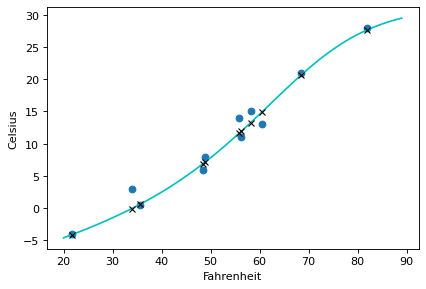

In [ ]:
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=80)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
plt.show()

We can appreciate that the neural network has a tendency to overfit, as we discussed in chapter 5, since it tries to chase the measurements, including the noisy ones. Even our tiny neural network has too many parameters to fit the few measurements we have. It doesn’t do a bad job, though, overall.

Let's also try on some other settings:

In [ ]:
neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

Epoch 1, Training loss 203.5335, Validation loss 118.4287
Epoch 1000, Training loss 59.5160, Validation loss 22.2755
Epoch 2000, Training loss 41.0913, Validation loss 12.3683
Epoch 3000, Training loss 24.4838, Validation loss 4.2068
Epoch 4000, Training loss 14.3510, Validation loss 1.4790
Epoch 5000, Training loss 8.6575, Validation loss 1.7794


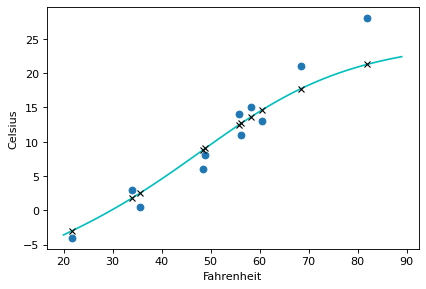

In [ ]:
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=80)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
plt.show()

## Dataset Classes

PyTorch supports map- and iterable-style dataset classes. A map-style dataset is derived from the abstract class torch.utils.data.Dataset. It implements the getitem() and len() functions, and represents a map from (possibly nonintegral) indices/keys to data samples. For example, such a dataset, when accessed with dataset[idx], could read the idx-th image and its corresponding label from a folder on the disk. Map-style datasets are more commonly used than iterable-style datasets, and all datasets that represent a map made from keys or data samples should use this subclass.

The simplest way to create your own dataset class is to subclass the map-style torch.utils.data.Dataset class and override the getitem() and len() functions with your own code.

All subclasses should overwrite getitem(), which fetches a data sample for a given key. Subclasses can also optionally overwrite len(), which returns the size of the dataset by many Sampler implementations and the default options of DataLoader.

An iterable-style dataset, on the other hand, is derived from the torch.utils.data.IterableDataset abstract class. It implements the iter() protocol and represents an iterable over data samples. This type of dataset is typically used when reading data from a database or a remote server, as well as data generated in real time. Iterable datasets are useful when random reads are expensive or uncertain, and when the batch size depends on fetched data.

The Dataset class returns a dataset object that includes data and information about the data. The dataset and sampler objects are not iterables, meaning you cannot run a for loop on them. The dataloader object solves this problem. The DataLoader class combines a dataset with a sampler and returns an iterable.

## The PyTorch NN Module (torch.nn)

One of the most powerful features of PyTorch is its Python module torch.nn, which makes it easy to design and experiment with new models. The following code illustrates how you can create a simple model with torch.nn. In this example, we will create a fully connected model called SimpleNet. It consists of an input layer, a hidden layer, and an output layer that takes in 2,048 input values and returns 2 output values for classification:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64,2)

    def forward(self, x):
        x = x.view(-1, 2048)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        return x

Creating a model in PyTorch is said to be very “Pythonic,” meaning it creates objects in the preferred Python fashion. We first create a new subclass called SimpleNet that inherits from the nn.Module class, and then we define the __init__() and forward() methods. The __init__() function initializes the model parameters and the forward() function defines how data is passed through our model.

In __init__(), we call the super() function to execute the parent nn.Module class’s __init__() method to initialize the class parameters. Then we define some layers using the nn.Linear module.

The forward() function defines how data is passed through the network. In the forward() function, we first use view() to reshape the input into a 2,048-element vector, then we process the input through each layer and apply relu() activation functions. Finally, we apply the softmax() function and return the output.

In [ ]:
simplenet = SimpleNet()
print(simplenet)

SimpleNet(
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
input = torch.rand(2048)
output = simplenet(input)

## The Perceptron: The Simplest Neural Network

The simplest neural network unit is a perceptron. The perceptron was historically and very loosely modeled after the biological neuron. As with a biological neuron, there is input and output, and “signals” flow from the inputs to the outputs.

Each perceptron unit has an input (x), an output (y), and three “knobs”: a set of weights (w), a bias (b), and an activation function (f). The weights and the bias are learned from the data, and the activation function is handpicked depending on the network designer’s intuition of the network and its target outputs.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

# Global Settings
LEFT_CENTER = (3, 3)
RIGHT_CENTER = (3, -2)

seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [ ]:
class Perceptron(nn.Module):
    """ A Perceptron is one Linear layer """

    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x_in):
        """The forward pass of the MLP

        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
        Returns:
            the resulting tensor. tensor.shape should be (batch, 1)
        """
        return torch.sigmoid(self.fc1(x_in))

In machine learning, it is a common practice to create synthetic data with well-understood properties when trying to understand an algorithm. For this section, we use synthetic data for the task of classifying two-dimensional points into one of two classes. To construct the data, we sample the points from two different parts of the xy-plane, creating an easy-to-learn situation for the model. The goal of the model is to classify the stars (⋆) as one class, and the circles (◯) as another class. This is visualized on the righthand side, where everything above the line is classified differently than everything below the line.

In [ ]:
def get_toy_data(batch_size, left_center=LEFT_CENTER, right_center=RIGHT_CENTER):
    x_data = []
    y_targets = np.zeros(batch_size)
    for batch_i in range(batch_size):
        if np.random.random() > 0.5:
            x_data.append(np.random.normal(loc=left_center))
        else:
            x_data.append(np.random.normal(loc=right_center))
            y_targets[batch_i] = 1
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.float32)

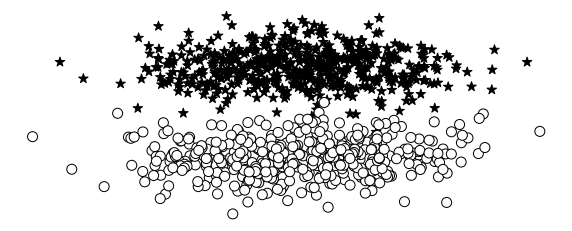

In [ ]:
x_data, y_truth = get_toy_data(batch_size=1000)

x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy()

left_x = []
right_x = []
left_colors = []
right_colors =  []

for x_i, y_true_i in zip(x_data, y_truth):
    color = 'black'

    if y_true_i == 0:
        left_x.append(x_i)
        left_colors.append(color)

    else:
        right_x.append(x_i)
        right_colors.append(color)

left_x = np.stack(left_x)
right_x = np.stack(right_x)

_, ax = plt.subplots(1, 1, figsize=(10,4))

ax.scatter(left_x[:, 0], left_x[:, 1], color=left_colors, marker='*', s=100)
ax.scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor=right_colors, marker='o', s=100)

plt.axis('off');

In [ ]:
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, 
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    y_pred = perceptron(x_data)
    y_pred = (y_pred > 0.5).long().data.numpy().astype(np.int32)

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy().astype(np.int32)

    n_classes = 2

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ['black', 'white']
    markers = ['o', '*']
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
        #all_colors[y_true_i].append(colors[y_pred_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))
        
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=300)
    
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
            
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))
            
    # hyperplane
    
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    Z = perceptron(torch.tensor(xy, dtype=torch.float32)).detach().numpy().reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=levels, linestyles=linestyles)    
    
    plt.suptitle(title)
    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

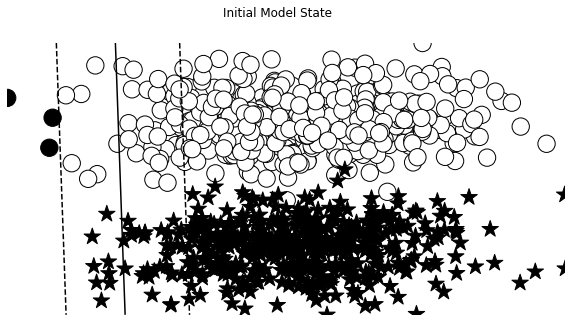

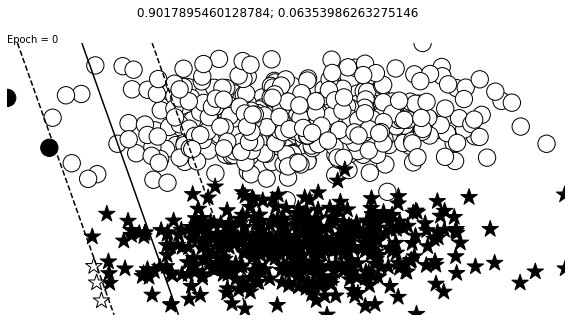

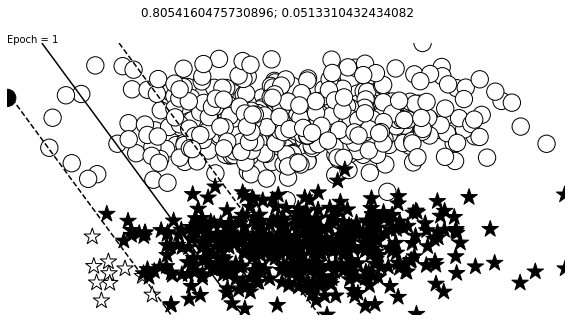

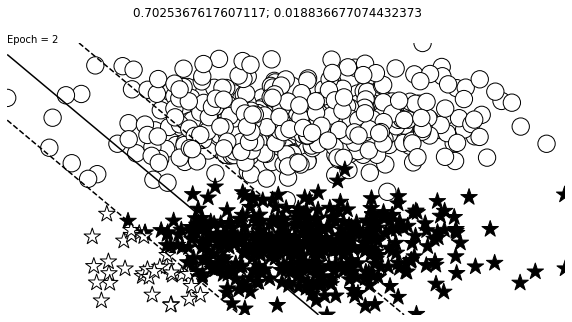

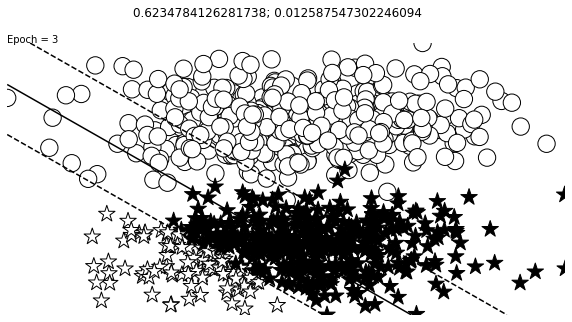

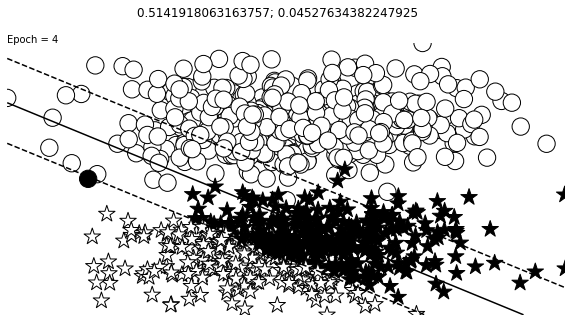

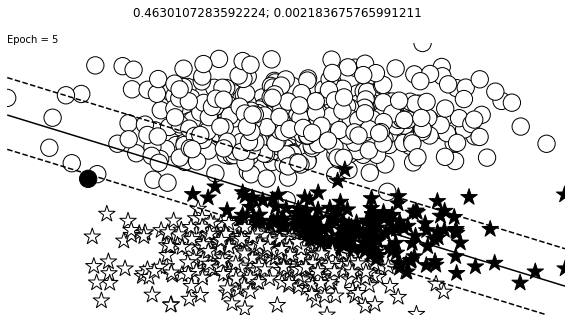

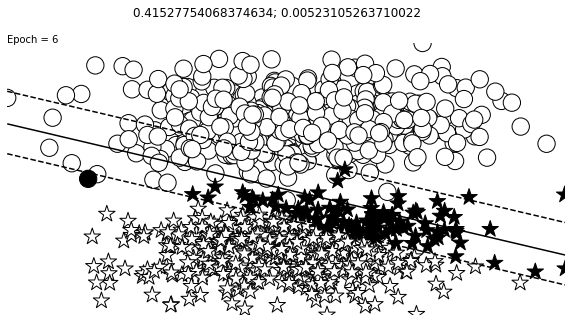

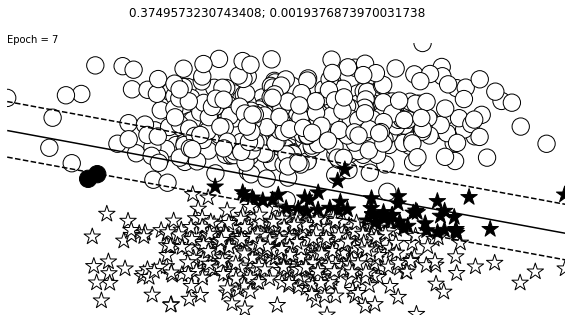

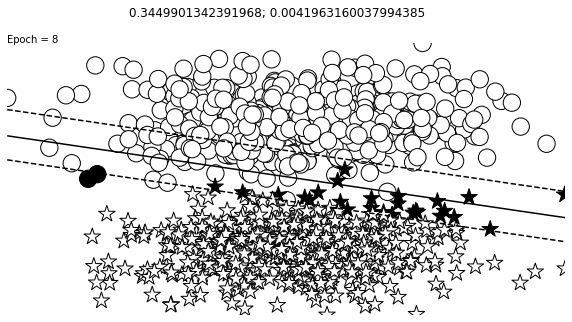

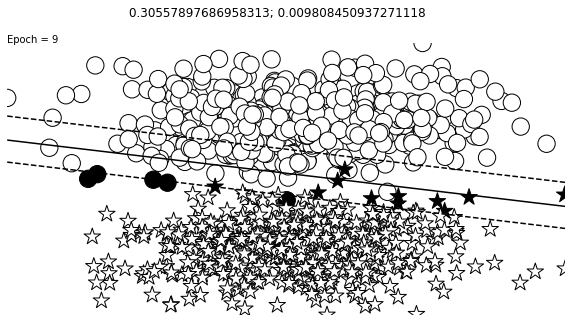

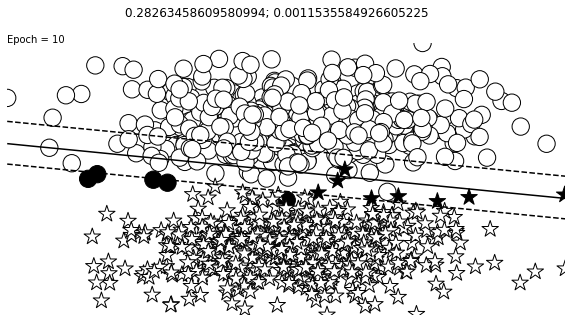

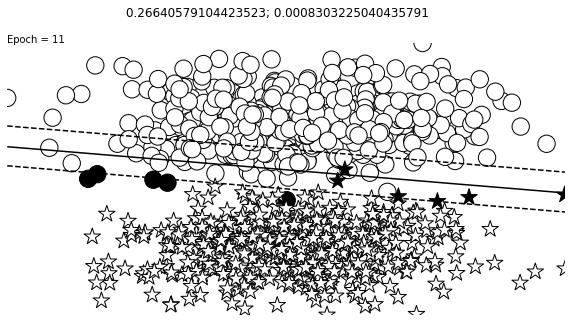

In [ ]:
lr = 0.01
input_dim = 2

batch_size = 1000
n_epochs = 12
n_batches = 5

perceptron = Perceptron(input_dim=input_dim)
optimizer = optim.Adam(params=perceptron.parameters(), lr=lr)
bce_loss = nn.BCELoss()

losses = []

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, title='Initial Model State')
plt.axis('off')
#plt.savefig('initial.png')

change = 1.0
last = 10.0
epsilon = 1e-3
epoch = 0
while change > epsilon or epoch < n_epochs or last > 0.3:
#for epoch in range(n_epochs):
    for _ in range(n_batches):

        optimizer.zero_grad()
        x_data, y_target = get_toy_data(batch_size)
        y_pred = perceptron(x_data).squeeze()
        loss = bce_loss(y_pred, y_target)
        loss.backward()
        optimizer.step()
        
        
        loss_value = loss.item()
        losses.append(loss_value)

        change = abs(last - loss_value)
        last = loss_value
               
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f"{loss_value}; {change}")
    plt.axis('off')
    epoch += 1
    #plt.savefig('epoch{}_toylearning.png'.format(epoch))

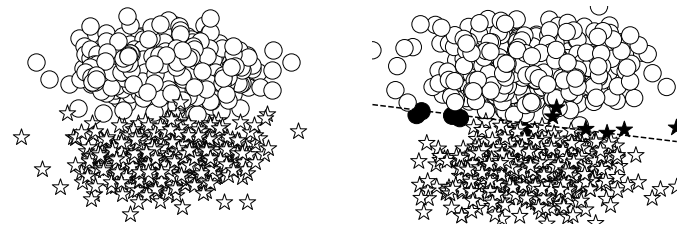

In [ ]:
_, axes = plt.subplots(1,2,figsize=(12,4))

axes[0].scatter(left_x[:, 0], left_x[:, 1], facecolor='white',edgecolor='black', marker='o', s=300)
axes[0].scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor='black', marker='*', s=300)
axes[0].axis('off');
visualize_results(perceptron, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1])
axes[1].axis('off');
plt.savefig('perceptron_final.png')
plt.savefig('perceptron_final.pdf')

## The Multilayer Perceptron

The multilayer perceptron is considered one of the most basic neural network building blocks. The simplest MLP is an extension to the perceptron. The perceptron takes the data vector as input and computes a single output value. In an MLP, many perceptrons are grouped so that the output of a single layer is a new vector instead of a single output value. In PyTorch, this is done simply by setting the number of output features in the Linear layer. An additional aspect of an MLP is that it combines multiple layers with a nonlinearity in between each layer.

The simplest MLP is composed of three stages of representation and two Linear layers. The first stage is the input vector. This is the vector that is given to the model. Given the input vector, the first Linear layer computes a hidden vector—the second stage of representation. The hidden vector is called such because it is the output of a layer that’s between the input and the output. What do we mean by “output of a layer”? One way to understand this is that the values in the hidden vector are the output of different perceptrons that make up that layer. Using this hidden vector, the second Linear layer computes an output vector. In a multiclass setting, the size of the output vector is equal to the number of classes. Always, the final hidden vector is mapped to the output vector using a combination of Linear layer and a nonlinearity.

Let’s take a look at the XOR example described earlier and see what would happen with a perceptron versus an MLP. In this example, we train both the perceptron and an MLP in a binary classification task: identifying stars and circles. Each data point is a 2D coordinate. Without diving into the implementation details yet, the final model predictions are shown in figure below. In this plot, incorrectly classified data points are filled in with black, whereas correctly classified data points are not filled in. In the left panel, you can see that the perceptron has difficulty in learning a decision boundary that can separate the stars and circles, as evidenced by the filled in shapes. However, the MLP (right panel) learns a decision boundary that classifies the stars and circles much more accurately.

<img src='https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781491978221/files/assets/nlpp_0403.png'>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the MLP
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate = F.relu(self.fc1(x_in))
        output = self.fc2(intermediate)
        
        if apply_softmax:
            output = F.softmax(output, dim=1)
        return output

Let's instantiate the MLP. Due to the generality of the MLP implementation, we can model inputs of any size. To demonstrate, we use an input dimension of size 3, an output dimension of size 4, and a hidden dimension of size 100. Notice how in the output of the print statement, the number of units in each layer nicely line up to produce an output of dimension 4 for an input of dimension 3.

In [ ]:
batch_size = 2 # number of samples input at once
input_dim = 3
hidden_dim = 100
output_dim = 4

# Initialize model
mlp = MultilayerPerceptron(input_dim, hidden_dim, output_dim)
print(mlp)

MultilayerPerceptron(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)


We can quickly test the “wiring” of the model by passing some random inputs. Because the model is not yet trained, the outputs are random. Doing this is a useful sanity check before spending time training a model. Notice how PyTorch’s interactivity allows us to do all this in real time during development, in a way not much different from using NumPy or Pandas.

In [ ]:
def describe(x):
    print("Type: {}".format(x.type()))
    print("Shape/size: {}".format(x.shape))
    print("Values: \n{}".format(x))

x_input = torch.rand(batch_size, input_dim)
describe(x_input)

Type: torch.FloatTensor
Shape/size: torch.Size([2, 3])
Values: 
tensor([[0.8329, 0.4277, 0.4363],
        [0.9686, 0.6316, 0.8494]])


In [ ]:
y_output = mlp(x_input, apply_softmax=False)
describe(y_output)

Type: torch.FloatTensor
Shape/size: torch.Size([2, 4])
Values: 
tensor([[-0.2456,  0.0723,  0.1589, -0.3294],
        [-0.3497,  0.0828,  0.3391, -0.4271]], grad_fn=<AddmmBackward>)


It is important to learn how to read inputs and outputs of PyTorch models. In the preceding example, the output of the MLP model is a tensor that has two rows and four columns. The rows in this tensor correspond to the batch dimension, which is the number of data points in the minibatch. The columns are the final feature vectors for each data point. In some cases, such as in a classification setting, the feature vector is a prediction vector. The name “prediction vector” means that it corresponds to a probability distribution. What happens with the prediction vector depends on whether we are currently conducting training or performing inference. During training, the outputs are used as is with a loss function and a representation of the target class labels.

However, if you want to turn the prediction vector into probabilities, an extra step is required. Specifically, you require the softmax activation function, which is used to transform a vector of values into probabilities. The softmax function has many roots. In physics, it is known as the Boltzmann or Gibbs distribution; in statistics, it’s multinomial logistic regression; and in the natural language processing (NLP) community it’s known as the maximum entropy (MaxEnt) classifier.7 Whatever the name, the intuition underlying the function is that large positive values will result in higher probabilities, and lower negative values will result in smaller probabilities.

In [ ]:
y_output = mlp(x_input, apply_softmax=True)
describe(y_output)

Type: torch.FloatTensor
Shape/size: torch.Size([2, 4])
Values: 
tensor([[0.2087, 0.2868, 0.3127, 0.1919],
        [0.1832, 0.2824, 0.3649, 0.1696]], grad_fn=<SoftmaxBackward>)


To conclude, MLPs are stacked Linear layers that map tensors to other tensors. Nonlinearities are used between each pair of Linear layers to break the linear relationship and allow for the model to twist the vector space around. In a classification setting, this twisting should result in linear separability between classes. Additionally, you can use the softmax function to interpret MLP outputs as probabilities, but you should not use softmax with specific loss functions, because the underlying implementations can leverage superior mathematical/computational shortcuts.

## Image Neural Model

In [7]:
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.ToTensor()
])

# Datasets
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Dataloaders to feed the data in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

print('No. of train images: {}'.format(len(trainset)))
print('No. of test images: {}'.format(len(testset)))
print('No. of train batches: {}'.format(len(trainloader)))
print('No. of test batches: {}'.format(len(testloader)))

No. of train images: 60000
No. of test images: 10000
No. of train batches: 60
No. of test batches: 100


In [8]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(12 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.reshape(-1, 12 * 4 * 4)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        return x

In [9]:
def find_acc(pred, label):
    """pixelwise accuracy"""
    correct = pred.argmax(dim = 1).eq(label)
    accuracy = correct.to(torch.float32).mean().item() * 100
    return accuracy


def train(network, epoch, criterion, optimizer, trainloader):
    loss_train = 0
    acc_train = 0
    network.train()
    
    for step in range(len(trainloader)):

        images , labels = next(iter(trainloader))
        
        # move the images and labels to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        pred = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(pred , labels)
        
        # find accuracy
        acc_train_step = find_acc(pred, labels)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        acc_train += acc_train_step  
            
        loss_train /= len(trainloader)
        acc_train /= len(testloader)

        return loss_train, acc_train  
        
        
def validate(network, epoch, criterion, testloader): 
    loss_valid = 0
    acc_valid = 0       
    network.eval()  

    for step in range(len(testloader)):

        images , labels = next(iter(testloader))
        
        # move the images and labels to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        pred = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss and acc for the current step
        loss_valid_step = criterion(pred , labels)
        acc_valid_step = find_acc(pred, labels)
      
        loss_valid += loss_valid_step.item()
        acc_valid += acc_valid_step

        loss_valid /= len(trainloader)
        acc_valid /= len(testloader)

        return loss_valid, acc_valid

In [10]:
network = Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=0.005)

num_epochs = 10
start_time = time.time()

for epoch in range(1, num_epochs+1):
    
    loss_train, acc_train = train(network, epoch, criterion, optimizer, trainloader)
    loss_valid, acc_valid = validate(network, epoch, criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

print("Time Elapsed : {:.4f}s".format(time.time() - start_time))

torch.save(network.state_dict(), "model.h5")

Epoch: 1  Train Loss: 0.0384  Train Acc: 0.1000  Valid Loss: 0.0382  Valid Acc: 0.1500
Epoch: 2  Train Loss: 0.0383  Train Acc: 0.1350  Valid Loss: 0.0379  Valid Acc: 0.2300
Epoch: 3  Train Loss: 0.0380  Train Acc: 0.1840  Valid Loss: 0.0374  Valid Acc: 0.3500
Epoch: 4  Train Loss: 0.0375  Train Acc: 0.3170  Valid Loss: 0.0366  Valid Acc: 0.2700
Epoch: 5  Train Loss: 0.0366  Train Acc: 0.3000  Valid Loss: 0.0353  Valid Acc: 0.3400
Epoch: 6  Train Loss: 0.0354  Train Acc: 0.3720  Valid Loss: 0.0334  Valid Acc: 0.4000
Epoch: 7  Train Loss: 0.0335  Train Acc: 0.5070  Valid Loss: 0.0309  Valid Acc: 0.3900
Epoch: 8  Train Loss: 0.0312  Train Acc: 0.4660  Valid Loss: 0.0286  Valid Acc: 0.5200
Epoch: 9  Train Loss: 0.0290  Train Acc: 0.5050  Valid Loss: 0.0264  Valid Acc: 0.4900
Epoch: 10  Train Loss: 0.0264  Train Acc: 0.5470  Valid Loss: 0.0243  Valid Acc: 0.5400
Time Elapsed : 6.4947s


In [11]:
def test_model(model):

    start_time = time.time()

    num_correct = 0
    accuracy = 0

    with torch.no_grad():

        for batch in testloader:

            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            total_images = len(testset)

            pred = model(images)

            num_correct_batch = pred.argmax(dim = 1).eq(labels).sum().item()

            accuracy_batch = pred.argmax(dim = 1).eq(labels).float().mean().item()

            num_correct += num_correct_batch
            accuracy += accuracy_batch

        accuracy /= len(testloader)

    print('Number of test images: {}'.format(total_images))
    print('Number of correct predictions: {}'.format(num_correct))
    print('Accuracy: {}'.format(accuracy * 100))

    print("Time Elapsed : {:.4f}s".format(time.time() - start_time))
    
# test the trained network    
test_model(network)    

Number of test images: 10000
Number of correct predictions: 5580
Accuracy: 55.799999803304665
Time Elapsed : 1.5537s


## Linear Regression

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams.update({'font.size': 16})

In [13]:
x = torch.rand(20, 5)
x

tensor([[0.0247, 0.5804, 0.6351, 0.7535, 0.0089],
        [0.6606, 0.2379, 0.5669, 0.4678, 0.8564],
        [0.8111, 0.2537, 0.9507, 0.5712, 0.0985],
        [0.1759, 0.1709, 0.6917, 0.0379, 0.5138],
        [0.3299, 0.8764, 0.4889, 0.9616, 0.3959],
        [0.8186, 0.3144, 0.0861, 0.4295, 0.6138],
        [0.1872, 0.0836, 0.3833, 0.1820, 0.4921],
        [0.6746, 0.6487, 0.3425, 0.7972, 0.7711],
        [0.9162, 0.2550, 0.9624, 0.9223, 0.6067],
        [0.9402, 0.3548, 0.6309, 0.9777, 0.8523],
        [0.9641, 0.6582, 0.4960, 0.8282, 0.9987],
        [0.5216, 0.1469, 0.1933, 0.0558, 0.5462],
        [0.1168, 0.3665, 0.2524, 0.5927, 0.5074],
        [0.9839, 0.5169, 0.8867, 0.7454, 0.9383],
        [0.0682, 0.7628, 0.6876, 0.8078, 0.1992],
        [0.7100, 0.7376, 0.5474, 0.9188, 0.1415],
        [0.3615, 0.9600, 0.7234, 0.0230, 0.9815],
        [0.7484, 0.2812, 0.6441, 0.6448, 0.4908],
        [0.0400, 0.0779, 0.4354, 0.0694, 0.3190],
        [0.9839, 0.3148, 0.9563, 0.3599, 0.2827]])

In [14]:
input_dim = 1
output_dim = 1

W = 2 * np.random.rand(output_dim, input_dim) - 1
b = 2 * np.random.rand(output_dim) - 1

true_model = lambda x: W @ x + b

In [15]:
n_train = 1000
noise_level = 0.04

# Generate a random set of n_train samples
X_train = np.random.rand(n_train, input_dim)
y_train = np.array([true_model(x) for x in X_train])

# Add some noise
y_train += noise_level * np.random.standard_normal(size=y_train.shape)

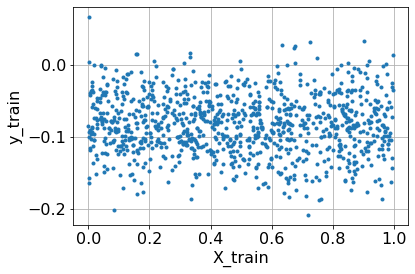

In [16]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(X_train, y_train, '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.set_ylabel('y_train')

In [17]:
class VectorialDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, output_data):
        super(VectorialDataset, self).__init__()
        self.input_data = torch.tensor(input_data.astype('f'))
        self.output_data = torch.tensor(output_data.astype('f'))
        
    def __len__(self):
        return self.input_data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = (self.input_data[idx, :], 
                  self.output_data[idx, :])  
        return sample 

In [19]:
training_set = VectorialDataset(input_data=X_train, output_data=y_train)
training_set[10:12]

(tensor([[0.3506],
        [0.4893]]), tensor([[-0.1045],
        [-0.0683]]))


In [20]:
train_loader = torch.utils.data.DataLoader(training_set, 
                                           batch_size=120, 
                                           shuffle=True)

In [21]:
import torch.nn as nn
import torch


class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.linear = nn.Linear(self.input_dim, self.output_dim, bias=True)

    def forward(self, x):
        out = self.linear(x)
        return out
    
    def reset(self):
        self.linear.reset_parameters()

In [22]:
model = LinearModel(input_dim, output_dim)
model

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [23]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0274]], requires_grad=True), Parameter containing:
 tensor([-0.3942], requires_grad=True)]

In [24]:
model.linear.weight

Parameter containing:
tensor([[-0.0274]], requires_grad=True)

In [25]:
model.linear.bias

Parameter containing:
tensor([-0.3942], requires_grad=True)

In [26]:
x = torch.randn(5, input_dim)
model.forward(x)

tensor([[-0.3852],
        [-0.3906],
        [-0.3929],
        [-0.3403],
        [-0.3974]], grad_fn=<AddmmBackward>)

In [27]:
[model.linear.weight @ xx + model.linear.bias for xx in x]

[tensor([-0.3852], grad_fn=<AddBackward0>),
 tensor([-0.3906], grad_fn=<AddBackward0>),
 tensor([-0.3929], grad_fn=<AddBackward0>),
 tensor([-0.3403], grad_fn=<AddBackward0>),
 tensor([-0.3974], grad_fn=<AddBackward0>)]

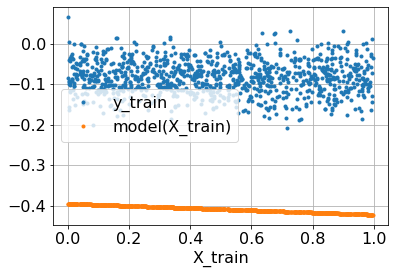

In [28]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(training_set.input_data, training_set.output_data, '.')
    ax.plot(training_set.input_data, model.forward(training_set.input_data).detach().numpy(), '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.legend(['y_train', 'model(X_train)']) 

In [29]:
import torch.nn as nn

loss_fun = nn.MSELoss(reduction='mean')
x = torch.tensor(np.array([1, 2, 1]).astype('f'))
z = torch.tensor(np.array([0, 0, 0]).astype('f'))
loss_fun(x, z)

tensor(2.)

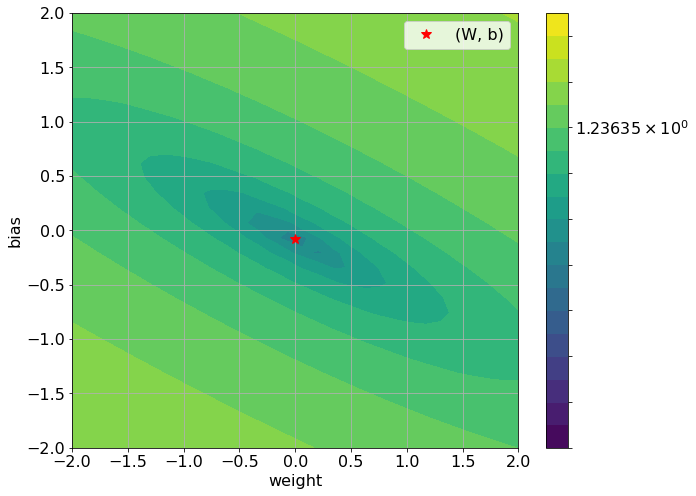

In [32]:
if input_dim == output_dim == 1:

    state_dict = model.state_dict()

    ww, bb = np.meshgrid(np.linspace(-2, 2, 30), np.linspace(-2, 2, 30))

    loss_values = 0 * ww
    for i in range(ww.shape[0]):
        for j in range(ww.shape[1]):
            state_dict['linear.weight'] = torch.tensor([[ww[i, j]]])
            state_dict['linear.bias'] = torch.tensor([bb[i, j]])
            model.load_state_dict(state_dict)
            loss_values[i, j] = loss_fun(model.forward(training_set.input_data),  training_set.output_data)

    fig = plt.figure(figsize=(10, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    c=ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    plt.colorbar(c)
    ax.plot(W[0], b, 'r*', markersize=10)
    ax.set_ylabel('bias')
    ax.set_xlabel('weight')
    ax.legend(['(W, b)'])
    
    ax.grid(True)  

In [33]:
x = torch.randn(1, input_dim)
y =  torch.randn(1, output_dim)

model.zero_grad()
loss = loss_fun(model.forward(x),  y)
loss.backward()

if input_dim == output_dim == 1:
    print(model.linear.weight.grad)
    print(2 * x * (model.linear.weight * x + model.linear.bias - y))
    
    print(model.linear.bias.grad)
    print(2 * (model.linear.weight * x + model.linear.bias - y))

tensor([[-1.6953]])
tensor([[-1.6953]], grad_fn=<MulBackward0>)
tensor([4.3905])
tensor([[4.3905]], grad_fn=<MulBackward0>)


In [34]:
if input_dim == output_dim == 1:

    num_iter = 200
    lr = 0.5 # 0.01

    train_hist = {}
    train_hist['weight'] = []
    train_hist['bias'] = []

    model.reset()
    state_dict = model.state_dict()

    for _ in range(num_iter):

        model.zero_grad()
        loss = loss_fun(model.forward(training_set.input_data), training_set.output_data)
        loss.backward()

        w = model.linear.weight.item()
        b = model.linear.bias.item()

        dw = model.linear.weight.grad.item()
        db = model.linear.bias.grad.item()

        state_dict['linear.weight'] += torch.tensor([-lr * dw])
        state_dict['linear.bias'] += torch.tensor([-lr * db])
        model.load_state_dict(state_dict)

        train_hist['weight'].append(w)
        train_hist['bias'].append(b)

    for label in train_hist:
        train_hist[label] = np.array(train_hist[label])

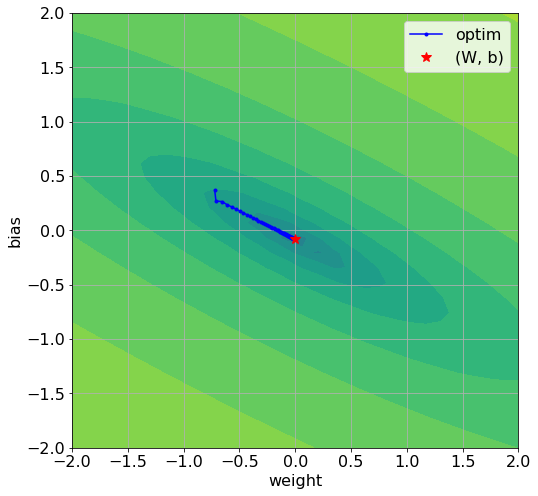

In [35]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(8, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    ax.grid(True)
    ax.set_xlim(-2, 2) 
    ax.set_ylim(-2, 2) 
    
    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(W[0], b, 'r*', markersize=10)

    ax.legend(['optim', '(W, b)'])

In [36]:
lr = 0.1
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

n_epochs = 100
train_hist = {}
train_hist['loss'] = []

if input_dim == output_dim == 1:
    train_hist['weight'] = []
    train_hist['bias'] = []

# Initialize training
model.reset()
model.train()

for epoch in range(n_epochs):
    for idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        loss = loss_fun(model.forward(batch[0]),  batch[1])
        loss.backward()
        optimizer.step()

        train_hist['loss'].append(loss.item())
        if input_dim == output_dim == 1:
            train_hist['weight'].append(model.linear.weight.item())
            train_hist['bias'].append(model.linear.bias.item())
        
        print('[Epoch %4d/%4d] [Batch %4d/%4d] Loss: % 2.2e' % (epoch + 1, n_epochs, 
                                                                idx + 1, len(train_loader), 
                                                                loss.item()))
        
model.eval()

[Epoch    1/ 100] [Batch    1/   9] Loss:  2.32e-01
[Epoch    1/ 100] [Batch    2/   9] Loss:  9.57e-02
[Epoch    1/ 100] [Batch    3/   9] Loss:  6.26e-02
[Epoch    1/ 100] [Batch    4/   9] Loss:  4.00e-02
[Epoch    1/ 100] [Batch    5/   9] Loss:  5.43e-02
[Epoch    1/ 100] [Batch    6/   9] Loss:  7.25e-02
[Epoch    1/ 100] [Batch    7/   9] Loss:  7.60e-02
[Epoch    1/ 100] [Batch    8/   9] Loss:  7.37e-02
[Epoch    1/ 100] [Batch    9/   9] Loss:  5.14e-02
[Epoch    2/ 100] [Batch    1/   9] Loss:  4.57e-02
[Epoch    2/ 100] [Batch    2/   9] Loss:  3.42e-02
[Epoch    2/ 100] [Batch    3/   9] Loss:  2.39e-02
[Epoch    2/ 100] [Batch    4/   9] Loss:  1.98e-02
[Epoch    2/ 100] [Batch    5/   9] Loss:  2.25e-02
[Epoch    2/ 100] [Batch    6/   9] Loss:  2.94e-02
[Epoch    2/ 100] [Batch    7/   9] Loss:  2.43e-02
[Epoch    2/ 100] [Batch    8/   9] Loss:  2.46e-02
[Epoch    2/ 100] [Batch    9/   9] Loss:  1.77e-02
[Epoch    3/ 100] [Batch    1/   9] Loss:  1.60e-02
[Epoch    3/

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [37]:
if input_dim == output_dim == 1:
    n_test = 500
    X_test = np.random.rand(n_test, input_dim)
    y_pred = []

    state_dict = model.state_dict()

    for idx in range(len(train_hist['weight'])):
        state_dict['linear.weight'] = torch.tensor([[train_hist['weight'][idx]]])
        state_dict['linear.bias'] = torch.tensor([train_hist['bias'][idx]])
        model.load_state_dict(state_dict)

        y_pred.append(model.forward(torch.tensor(X_test.astype('f'))).detach().numpy())    

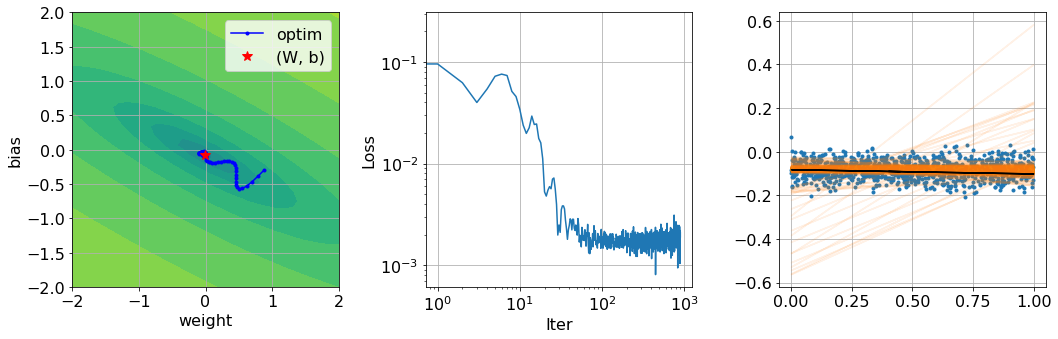

In [38]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(15, 5))
    fig.clf()
    
    ax = fig.add_subplot(1, 3, 1)
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(W[0], b, 'r*', markersize=10)
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    ax.legend(['optim', '(W, b)'])
    ax.grid(True)
    ax.set_xlim(-2, 2) 
    ax.set_ylim(-2, 2) 
    
    ax = fig.add_subplot(1, 3, 2)
    ax.loglog(np.abs(train_hist['loss']))
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.grid(True)
    
    ax = fig.add_subplot(1, 3, 3)
    ax.plot(X_train, y_train, '.')
    a=ax.plot(X_test, y_pred[0], '-', alpha=0.1)
    for y in y_pred[1:]:
        ax.plot(X_test, y, '-', alpha=0.1, color=a[0].get_color())
    ax.plot(X_test, y_pred[-1], 'k')
    ax.grid(True)   

    fig.tight_layout()

else:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.loglog(np.abs(train_hist['loss']))
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.grid(True)